<a href="https://colab.research.google.com/github/simingg/SiMing/blob/master/AugmentedCombined2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
import os
import sys
import argparse
from glob import glob
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from google.colab import drive

In [ ]:
import os


drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/combinedDataZip.zip'

Archive:  /content/drive/MyDrive/combinedDataZip.zip
  inflating: combinedData/annotations/Cars50.xml  
  inflating: combinedData/annotations/Cars80.xml  
  inflating: combinedData/annotations/Cars37.xml  
  inflating: combinedData/annotations/Cars356.xml  
  inflating: combinedData/annotations/Cars95.xml  
  inflating: combinedData/annotations/Cars386.xml  
  inflating: combinedData/annotations/Cars420.xml  
  inflating: combinedData/annotations/Cars29.xml  
  inflating: combinedData/annotations/Cars296.xml  
  inflating: combinedData/annotations/Cars339.xml  
  inflating: combinedData/annotations/Cars291.xml  
  inflating: combinedData/annotations/Cars260.xml  
  inflating: combinedData/annotations/Cars380.xml  
  inflating: combinedData/annotations/Cars157.xml  
  inflating: combinedData/annotations/Cars365.xml  
  inflating: combinedData/images/Cars90.jpg  
  inflating: combinedData/annotations/Cars124.xml  
  inflating: combinedData/annotations/Cars415.xml  
  inflating: combinedD

Create Data folder, then create images and annotations folder within Data

In [ ]:
!mkdir Data

In [ ]:
!mkdir Data/images

In [ ]:
!mkdir Data/annotations

In [ ]:
#creating test, valid, and training folders
!if [ -d '/content/Data/images/train' ]; then echo "Directory train in images already exist" ; else mkdir '/content/Data/images/train' && echo "Directory train in images created"; fi
!if [ -d '/content/Data/images/validation' ]; then echo "Directory valid in images already exist" ; else mkdir '/content/Data/images/validation' && echo "Directory valid in images created"; fi
!if [ -d '/content/Data/images/test' ]; then echo "Directory test in images already exist" ; else mkdir '/content/Data/images/test' && echo "Directory test in images created"; fi
print ("")

!if [ -d '/content/Data/annotations/train' ]; then echo "Directory train in annotations exist" ; else mkdir '/content/Data/annotations/train' && echo "Directory train in annotations created"; fi
!if [ -d '/content/Data/annotations/valid' ]; then echo "Directory valid in annotations exist" ; else mkdir '/content/Data/annotations/valid' && echo "Directory valid in annotations created"; fi
!if [ -d '/content/Data/annotations/test' ]; then echo "Directory test in annotations already exist" ; else mkdir '/content/Data/annotations/test' && echo "Directory test in annotations created"; fi
print ("")

Directory train in images created
Directory valid in images created
Directory test in images created

Directory train in annotations created
Directory valid in annotations created
Directory test in annotations created



In [ ]:
#split dataset to 80,20 then 80,20 for train and validation
import glob
img_dir = "/content/combinedData/images" # Enter Directory of all images 
files = [f for f in sorted(os.listdir(img_dir))]

#xml files
path = '/content/combinedData/annotations'
text_files = [f for f in sorted(os.listdir(path))]

In [ ]:
#check that number of train data tallies the number of output files
print(len(files), len(text_files))

1142 1142


In [ ]:
from sklearn.model_selection import train_test_split
training_data, testing_data, y_training_data, y_test = train_test_split(files, text_files, test_size=0.2, random_state=25)
train_data, validaton_data, y_train, y_valdate = train_test_split(training_data, y_training_data, test_size=0.2, random_state=25)


In [ ]:
#org size of dataset
len(train_data)

730

In [ ]:
## Copy files from sources to train
from shutil import copyfile  


## copy train image set
lenght = len(train_data)
for i in range(lenght):
  #print(train_data[i])
  src = ("/content/combinedData/images/" + train_data[i])
  dst = ("/content/Data/images/train/" + train_data[i])
  copyfile(src, dst)

## copy valid image set
lenght = len(validaton_data)
for i in range(lenght):
  src = ("/content/combinedData/images/" + validaton_data[i])
  dst = ("/content/Data/images/validation/" + validaton_data[i])
  copyfile(src, dst)

## copy test image set
lenght = len(testing_data)
for i in range(lenght):
  src = ("/content/combinedData/images/" + testing_data[i])
  dst = ("/content/Data/images/test/" + testing_data[i])
  copyfile(src, dst)



## copy train xml files
lenght = len(y_train)
for i in range(lenght):
  src = ("/content/combinedData/annotations/" + y_train[i])
  dst = ("/content/Data/annotations/train/" + y_train[i])
  copyfile(src, dst) 

## copy valid xml files
lenght = len(y_valdate)
for i in range(lenght):
  src = ("/content/combinedData/annotations/" + y_valdate[i])
  dst = ("/content/Data/annotations/valid/" + y_valdate[i])
  copyfile(src, dst)

#copy test xml files
lenght = len(y_test)
for i in range(lenght):
  src = ("/content/combinedData/annotations/" + y_test[i])
  dst = ("/content/Data/annotations/test/" + y_test[i])
  copyfile(src, dst)


In [ ]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    #for images whose license plates are cropped out
    xmin = 0
    ymin = 0
    xmax = 0
    ymax = 0
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [ ]:
def read_annotation_data(xml_fn):
    file = open(xml_fn,'r')
    tree = ET.parse(file)
    root = tree.getroot()
    size = root.find('size')
    imw = int(size.find('width').text)
    imh = int(size.find('height').text)
    objects = []
    
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)
        bb = [(xmin,ymin),(xmax,ymin),(xmax, ymax),(xmin,ymax)] # Top left, top right, bottom right, bottom left
        objects.append([cls,bb])

    return imw, imh, objects
    

In [ ]:
#### Define augmentation sequence ####
# This can be tweaked to create a huge variety of image augmentations.
# See https://github.com/aleju/imgaug for a list of augmentation techniques available.
seq1 = iaa.Sequential([
    iaa.Fliplr(0.5),                             # Horizontal flip 50% of images
    iaa.Crop(percent=(0, 0.20)),                 # Crop all images between 0% to 20%
    #iaa.GaussianBlur(sigma=(0, 1)),             # Add slight blur to images
    iaa.Multiply((0.7, 1.3), per_channel=0.2) # Slightly brighten, darken, or recolor images
##    iaa.Affine(
##        scale={"x": (0.8, 1.2), "y": (0.8,1.2)},                # Resize image
##        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Translate image
##        rotate=(-5, 5),                                         # Rotate image
##        mode=ia.ALL, cval=(0,255)                               # Filling in extra pixels
##        )
    ])


In [ ]:
# Function for finding bounding box from keypoints
def kps_to_BB(kps,imgW,imgH):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=1 # To make the bounding box a little bit bigger
    kpsx=[kp[0] for kp in kps]
    xmin=max(0,int(min(kpsx)-extend))
    xmax=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp[1] for kp in kps]
    ymin=max(0,int(min(kpsy)-extend))
    ymax=min(imgH,int(max(kpsy)+extend))
    if xmin==xmax or ymin==ymax:
        return None
    else:
        #return ia.BoundingBox(x1=xmin,y1=ymin,x2=xmax,y2=ymax)
        return [(xmin, ymin),(xmax, ymax)]

In [ ]:
# Define XML annotation format for creating new XML files
xml_body_1="""<annotation>
        <folder>{FOLDER}</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

In [ ]:
# Function to create XML files
def create_xml(folder, image_path, xml_path, size, imBBs):

    # Get image size and filename
    imH, imW = size[0], size[1]
    image_fn = os.path.split(image_path)[-1]

    # Create XML file and write data
    with open(xml_path,'w') as f:
        f.write(xml_body_1.format(**{'FOLDER':folder, 'FILENAME':image_fn, 'PATH':image_path,
                                     'WIDTH':imW, 'HEIGHT':imH}))

        for bbox in imBBs:
            f.write(xml_object.format(**{'CLASS':bbox[0], 'XMIN':bbox[1][0], 'YMIN':bbox[1][1],
                                          'XMAX':bbox[1][2], 'YMAX':bbox[1][3]}))

        f.write(xml_body_2)

    return

In [ ]:
#get image files
classes = ['licence', 'LP']
IMAGE_SIZE = 224
import glob
img_dir = "/content/Data/images/train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes

In [ ]:
IMG_EXTENSION = '.jpg'
xml_dir = "/content/Data/annotations/train"
cwd = os.getcwd()
for img_fn in files:
    # Open image, get shape and base filename
    original_img = cv2.imread(img_fn)
    imgH, imgW, _ = original_img.shape
    #print(imgH, imgW)
    base_img_fn = os.path.split(img_fn)[-1]
    base_fn = base_img_fn.replace(IMG_EXTENSION,'')
    
    # Read annotation data from image's corresponding XML file
    xml_fn = img_fn.replace(IMG_EXTENSION,'.xml')
    xml_fn = xml_fn.replace("/content/Data/images/train", "/content/Data/annotations/train")

    imgW_xml, imgH_xml, objects = read_annotation_data(xml_fn)

    if ((imgW_xml != imgW) or (imgH_xml != imgH)):
        print('Warning! Annotation data does not match image data for %s. Skipping image.' % img_fn)
        continue
    im_kps = []
    im_classes = []
    num_obj = len(objects)
    for obj in objects:
        im_classes.append(obj[0])
        im_kps.append(obj[1][0]) # Top left corner
        im_kps.append(obj[1][1]) # Top right corner
        im_kps.append(obj[1][2]) # Bottom right corner
        im_kps.append(obj[1][3]) # Bottom left corner

    # Define keypoints on image
    ia_kps = [ia.Keypoint(x=p[0], y=p[1]) for p in im_kps]
    original_kps = ia.KeypointsOnImage(ia_kps, shape=original_img.shape)

    # Create new augmented images, and save them in folder with annotation data
    for n in range(2):

        # Define new filenames
        img_aug_fn = base_fn + ('_aug%d' % (n+1)) + IMG_EXTENSION
        img_aug_path = os.path.join(cwd,img_dir,img_aug_fn)
        xml_aug_fn = img_aug_fn.replace(IMG_EXTENSION,'.xml')
        xml_aug_path = os.path.join(cwd,xml_dir,xml_aug_fn)

        # Augment image and keypoints.
        # First, copy original image and keypoints
        img = np.copy(original_img)
        kps = original_kps
        # Next, need to make sequence determinstic so it performs the same augmentation on image as it does on the keypoints
        seq1_det = seq1.to_deterministic()
        # Finally, run the image and keypoints through the augmentation sequence
        img_aug = seq1_det.augment_images([img])[0]
        kps_aug = seq1_det.augment_keypoints([kps])[0]
        imgH_aug, imgW_aug, _ = img_aug.shape

        # Extract augmented keypoints back into a list array, find BBs, and write annotation data to new file
        list_kps_aug = [(int(kp.x), int(kp.y)) for kp in kps_aug.keypoints]
        bboxes_aug = []
        bboxes_aug_data = []

        # Loop over every object, determine bounding boxes for new KPs, and save annotation data
        for i in range(num_obj):
            obj_aug_kps = list_kps_aug[i*4:(i*4+4)] # Augmented keypoints for each object
            obj_bb = kps_to_BB(obj_aug_kps,imgW_aug,imgH_aug) # Augmented bounding boxes for each object
            if obj_bb: # Sometimes the bbox coordinates are invalid and obj_bb is empty, so need to check if obj_bb valid
                bboxes_aug.append(obj_bb) # List of bounding boxes for each object
                xmin = int(obj_bb[0][0])
                ymin = int(obj_bb[0][1])
                xmax = int(obj_bb[1][0])
                ymax = int(obj_bb[1][1])
                coords = [xmin, ymin, xmax, ymax]
                label = im_classes[i]
                bboxes_aug_data.append([label, coords]) # List of bounding box data for each object (class name and box coordinates)

        # Save image and XML files to hard disk
        cv2.imwrite(img_aug_path,img_aug)
        create_xml(xml_dir, img_aug_fn, xml_aug_path, [imgH_aug,imgW_aug], bboxes_aug_data)

In [ ]:
path = "/content/Data/annotations/train"
text_files = ["/content/Data/annotations/train/"+f for f in sorted(os.listdir(path))] 

path_test = "/content/Data/annotations/test"
test_files =  ["/content/Data/annotations/test/"+f for f in sorted(os.listdir(path_test))] 

path_val = "/content/Data/annotations/valid"
val_files = ["/content/Data/annotations/valid/"+f for f in sorted(os.listdir(path_val))]
y=[] #contains the coorindates for images including new augmented images, sorted
y_val = []
y_test = []
for i in text_files:
  y.append(resizeannotation(i))

for j in test_files:
  y_test.append(resizeannotation(j))


for k in val_files:
  y_val.append(resizeannotation(k))

In [ ]:
IMAGE_SIZE=224

img_dir = "/content/Data/images/train" # re-read files with new aug images
data_path = os.path.join(img_dir,'*g')

files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes

img_dir_test = "/content/Data/images/test" # re-read files with new aug images
data_path_test = os.path.join(img_dir_test,'*g')

test_files = glob.glob(data_path_test)
test_files.sort() 

img_dir_val = "/content/Data/images/validation" # re-read files with new aug images
data_path_val = os.path.join(img_dir_val,'*g')

val_files = glob.glob(data_path_val)
val_files.sort()

img_fns=[] #images
img_test = []
img_val = []

for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE)) #standardize to 224 img size
    img_fns.append(np.array(img)) #transform img to array RGB(r,g,b) format

for f2 in test_files:
    img = cv2.imread(f2)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE)) #standardize to 224 img size
    img_test.append(np.array(img)) #transform img to array RGB(r,g,b) format

for f3 in val_files:
    img = cv2.imread(f3)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE)) #standardize to 224 img size
    img_val.append(np.array(img)) #transform img to array RGB(r,g,b) format

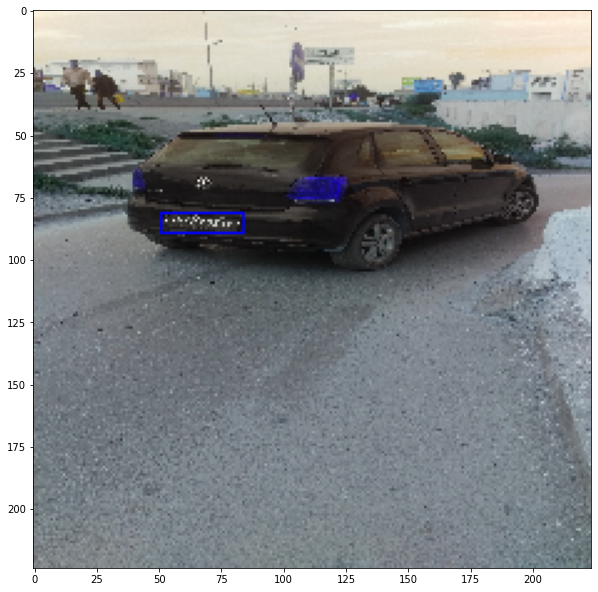

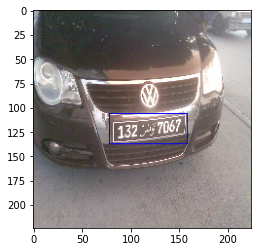

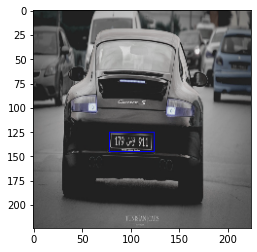

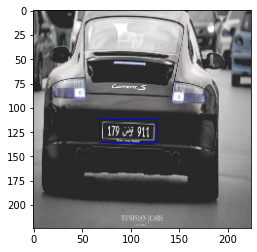

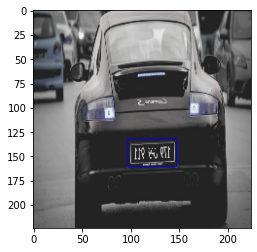

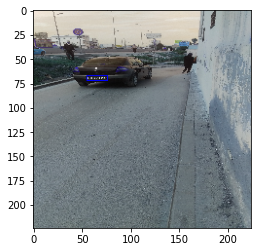

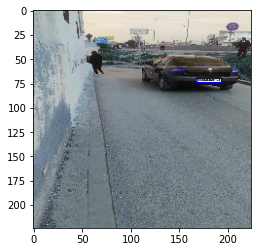

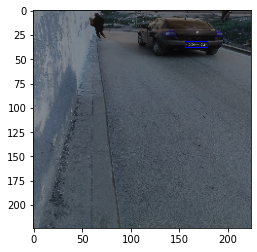

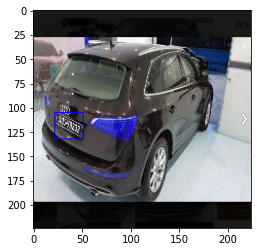

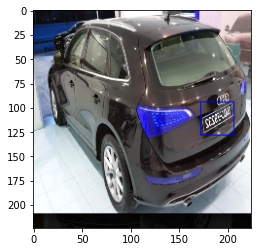

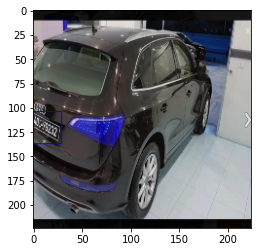

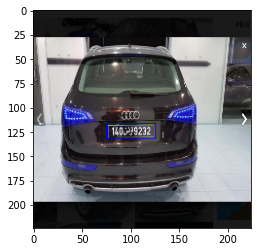

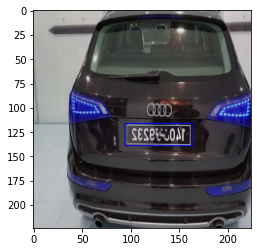

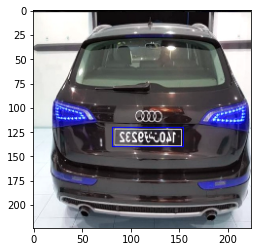

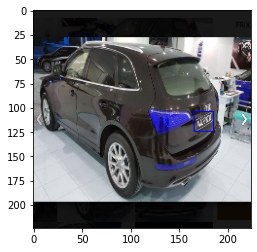

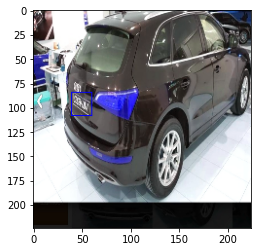

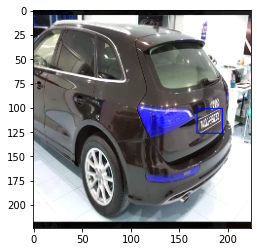

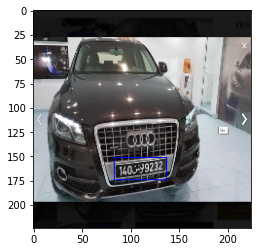

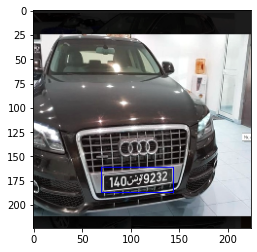

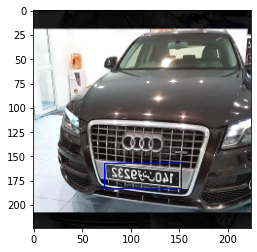

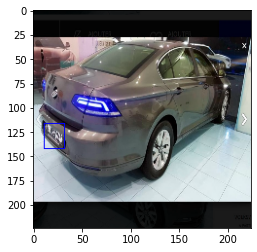

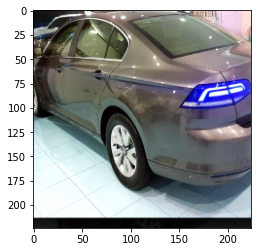

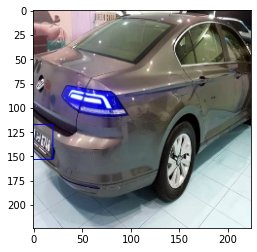

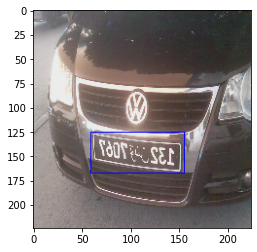

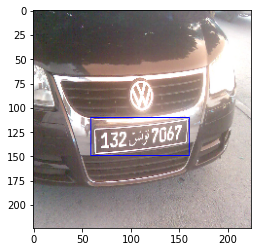

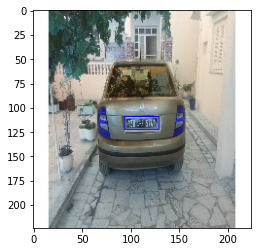

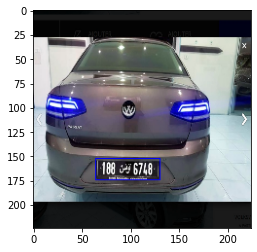

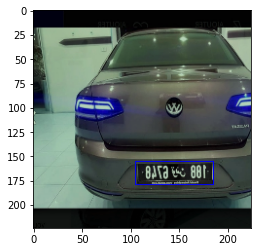

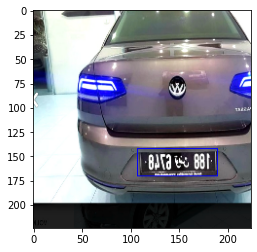

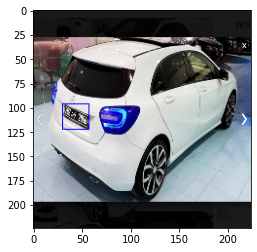

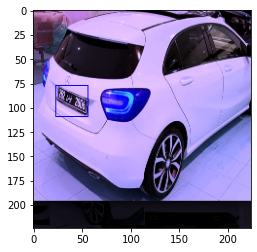

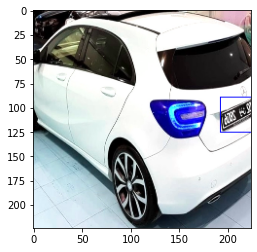

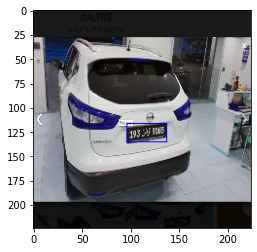

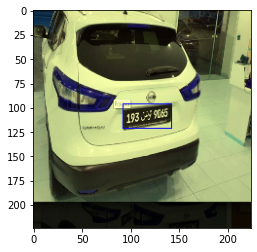

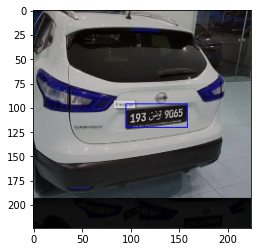

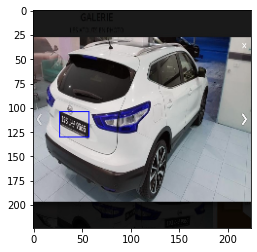

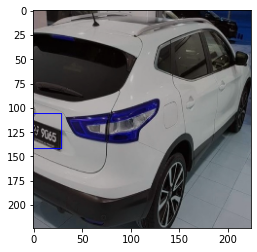

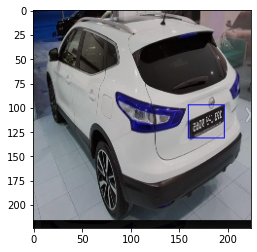

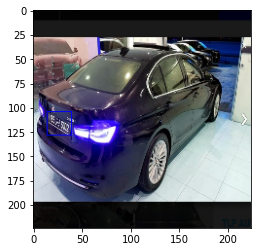

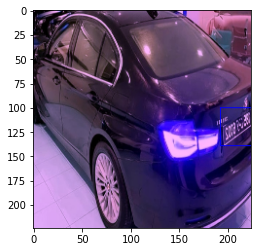

In [ ]:
from matplotlib import pyplot as plt
#test if BBox is accurate
plt.figure(figsize=(10,20))
for i in range(0,40) :
  ##print(img_fns[i])
  image = cv2.rectangle(img_fns[i],(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 0, 255))
  plt.imshow(image)
  plt.show()

In [ ]:
!zip -r /content/combinedSplitAugData.zip /content/Data

Streaming output truncated to the last 5000 lines.
  adding: content/Data/annotations/test/255.xml (deflated 47%)
  adding: content/Data/annotations/test/142.xml (deflated 46%)
  adding: content/Data/annotations/test/Cars107.xml (deflated 57%)
  adding: content/Data/annotations/test/225.xml (deflated 46%)
  adding: content/Data/annotations/test/306.xml (deflated 46%)
  adding: content/Data/annotations/test/Cars384.xml (deflated 57%)
  adding: content/Data/annotations/test/Cars82.xml (deflated 57%)
  adding: content/Data/annotations/test/Cars134.xml (deflated 57%)
  adding: content/Data/annotations/test/181.xml (deflated 46%)
  adding: content/Data/annotations/test/206.xml (deflated 46%)
  adding: content/Data/annotations/test/84.xml (deflated 47%)
  adding: content/Data/annotations/test/553.xml (deflated 46%)
  adding: content/Data/annotations/test/396.xml (deflated 46%)
  adding: content/Data/annotations/test/Cars194.xml (deflated 57%)
  adding: content/Data/annotations/test/Cars349.x

In [ ]:
#transform to array
X_train=(np.array(img_fns))/255
X_test = (np.array(img_test))/255
X_val = (np.array(img_val))/255

#coordinates
y_train=(np.array(y))/255
y_val = (np.array(y_val))/255
y_test = (np.array(y_test))/255

In [ ]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg19 import VGG19

In [ ]:
# Create the model
model = Sequential()
model.add(VGG19(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                         

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:

train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
69/69 [==============================] - 71s 473ms/step - loss: 0.0603 - accuracy: 0.5977 - val_loss: 0.0529 - val_accuracy: 0.6066
Epoch 2/20
69/69 [==============================] - 20s 298ms/step - loss: 0.0441 - accuracy: 0.6050 - val_loss: 0.0486 - val_accuracy: 0.6066
Epoch 3/20
69/69 [==============================] - 20s 297ms/step - loss: 0.0413 - accuracy: 0.6050 - val_loss: 0.0473 - val_accuracy: 0.6066
Epoch 4/20
69/69 [==============================] - 21s 298ms/step - loss: 0.0399 - accuracy: 0.6050 - val_loss: 0.0469 - val_accuracy: 0.6066
Epoch 5/20
69/69 [==============================] - 21s 298ms/step - loss: 0.0081 - accuracy: 0.8078 - val_loss: 0.0064 - val_accuracy: 0.8579
Epoch 6/20
69/69 [==============================] - 21s 299ms/step - loss: 0.0020 - accuracy: 0.8991 - val_loss: 0.0070 - val_accuracy: 0.8907
Epoch 7/20
69/69 [==============================] - 21s 298ms/step - loss: 0.0014 - accuracy: 0.9256 - val_loss: 0.0060 - val_accuracy: 0.8689

In [ ]:
model.save('model.h5', overwrite=True) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 23,260,804
Trainable params: 3,236,420
Non

In [ ]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 91.70%


In [ ]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(val_accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

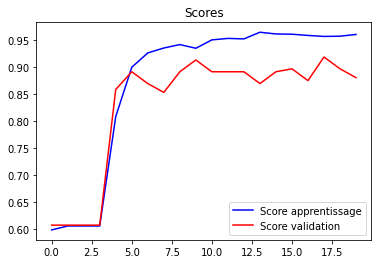

In [ ]:
plot_scores(train)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(87))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

87/87 [==============================] - 10s 96ms/step - loss: 0.0050 - accuracy: 0.9170
Test results 
 Loss: 0.004993528593331575 
 Accuracy 0.9170305728912354


In [ ]:
 y_cnn = model.predict(X_test)

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)